# Exploration

In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

from sklearn import manifold, decomposition, cluster
from sklearn.model_selection import train_test_split

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_comp.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

full_history = full_history.drop('index', axis=1)

As shown below, for every 19 songs listened to, 10 of them are unique to my music catalog.

In [3]:
def get_unique():
    unique_history = full_history.drop('timestamp', axis=1)
    return unique_history.drop_duplicates('id')

len(full_history)/len(get_unique())

1.9224489795918367

Here is a sample of artists. In addition to the a priori known name, we have followers, genres, and popularity of each artist.

In [4]:
artists = pd.read_json('data/artist_info.json')
artists.sample(5)

,artist,followers,genres,id,popularity
1635,Martin Volt,902,[progressive electro house],0Nca2TQcIrUaIRYwShmLrc,24
2349,Meltycanon,13259,[lo beats],3agnCimLdkVM3mc4PFJUxC,53
337,Andrew Manze,2913,"[baroque ensemble, choral, classical, classica...",0MPbAeGQj0YatrUMdY2KEr,55
395,Nikolaus Harnoncourt,40845,"[baroque ensemble, choral, classical, classica...",0AeOzXbHJu8q2xqILEOLEO,62
1318,Kailee Morgue,10853,[indie electro-pop],245PKF3hKjtxJKIG153kF0,57


### Visualizing Feature Space

Below we visualize the distributions of each feature. Pay close attention because we do make some modifications on a per-feature basis. These are designed to reduce error down the road.

In [5]:
def hist(X, xlim, bins=14):
    plt.xlim(xlim)
    N, bins, patches = plt.hist(X, bins=bins)

    fracs = N / N.max()

    norm = colors.Normalize(fracs.min(), fracs.max())

    for frac, patch in zip(fracs, patches):
        color = plt.cm.coolwarm(norm(frac))
        patch.set_facecolor(color)

count    10362.000000
mean         0.305218
std          0.313379
min          0.000003
25%          0.043500
50%          0.181500
75%          0.511000
max          0.996000
Name: acousticness, dtype: float64

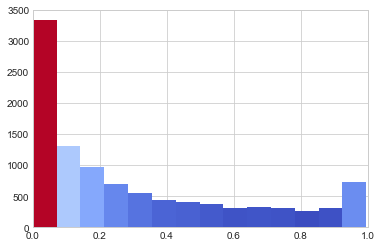

In [6]:
hist(full_history['acousticness'], [0,1])
full_history['acousticness'].describe()

count    10362.000000
mean         0.604638
std          0.169704
min          0.063400
25%          0.492000
50%          0.614000
75%          0.734000
max          0.984000
Name: danceability, dtype: float64

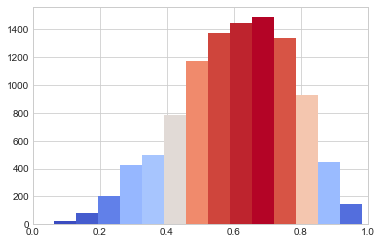

In [7]:
hist(full_history['danceability'], [0,1])
full_history['danceability'].describe()

Convert the duration of each song from milliseconds to floating-point minutes.

count    10362.000000
mean         3.867266
std          1.405493
min          0.566450
25%          3.156017
50%          3.666667
75%          4.321529
max         41.074900
Name: duration, dtype: float64


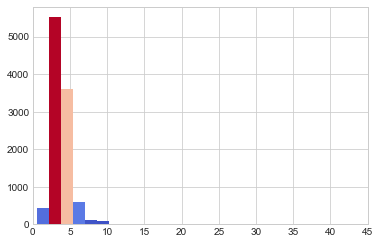

In [8]:
full_history['duration'] = full_history['duration_ms'] / 1000 / 60
full_history['duration'].describe()
hist(full_history['duration'], [0,45], 25)

In [11]:
full_history = full_history.drop('duration_ms', axis=1)

ValueError: labels ['duration_ms'] not contained in axis

count    10362.000000
mean         0.572375
std          0.226727
min          0.000803
25%          0.436000
50%          0.590500
75%          0.739000
max          0.998000
Name: energy, dtype: float64

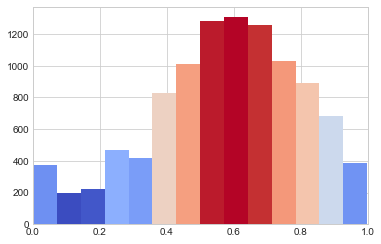

In [10]:
hist(full_history['energy'], [0,1])
full_history['energy'].describe()

count    10362.000000
mean         0.187516
std          0.152933
min          0.018700
25%          0.097900
50%          0.123000
75%          0.225000
max          0.989000
Name: liveness, dtype: float64

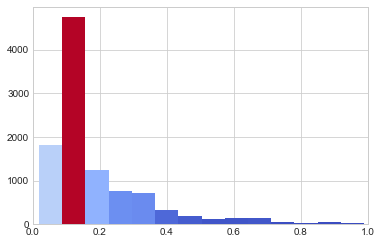

In [12]:
hist(full_history['liveness'], [0,1])
full_history['liveness'].describe()

In [13]:
full_history[full_history['liveness'] > 0.75].drop_duplicates('id')['name'][:15]

10010                             My Girls
10065                          Dude - Skit
10231                              Asshole
10337                              Feel Me
105                             So Special
1056                        Round Whippin'
1158                                  TEAM
1279                             Hound Dog
1290                          Candle Light
138                                 ALASKA
1469                             Champions
1502                                 Pt. 2
1522     Sunday Morning Coming Down - Live
1527                       Ragged Old Flag
1756                        Starting Today
Name: name, dtype: object

Liveness is obviously an inaccurate measurement, thus we cannot use it reliably. We remove it.

In [14]:
full_history = full_history.drop('liveness', axis=1)

Similar to duration, loudness is heavily skewed, thus we log scale it to bring things back together and reveal more of the underlying structure. Note the transformation of the values too. Since we don't care too much about the actual value of the loudness, only whether it's relatively loud or not, we assume this is acceptable.

count    10362.000000
mean         2.157971
std          0.456490
min         -0.529329
25%          1.876866
50%          2.124893
75%          2.374627
max          3.877990
Name: log_loudness, dtype: float64

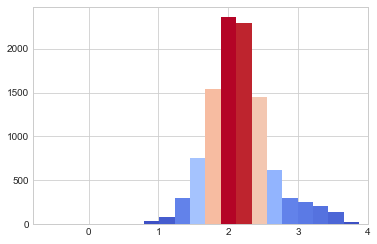

In [15]:
full_history['log_loudness'] = np.log(-1*full_history['loudness']+1)
hist(full_history['log_loudness'], [-0.8,4], 20)
full_history['log_loudness'].describe()

In [16]:
full_history = full_history.drop('loudness', axis=1)

count    10362.000000
mean        54.636557
std         17.303703
min          0.000000
25%         45.000000
50%         57.000000
75%         66.000000
max        100.000000
Name: popularity, dtype: float64

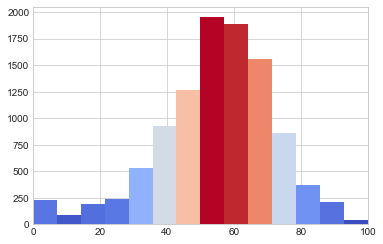

In [17]:
hist(full_history['popularity'], [0, 100])
full_history['popularity'].describe()

count    10362.000000
mean       117.801100
std         29.800043
min         32.000000
25%         94.000000
50%        118.000000
75%        140.000000
max        222.000000
Name: tempo, dtype: float64

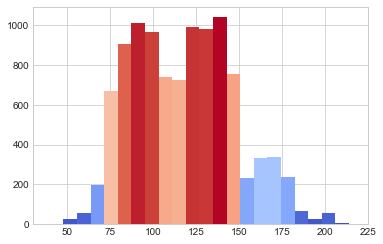

In [18]:
full_history['tempo'] = full_history['tempo'].apply(round)
hist(full_history['tempo'], [30, 225], 24)
full_history['tempo'].describe()

Many songs are misclassified by Spotify, often doubling the real BPM. Presto tempo is said to be above 168, and after looking through many of the resutls of songs above 168 BPM, it is reasonable to correct songs above this threshold. Although it does cut out the top end, it is more representative for  many songs.

In [19]:
full_history['tempo'] = full_history['tempo'].apply(lambda x: x if x < 168 else x/2)

count    10362.000000
mean         0.430213
std          0.236940
min          0.029800
25%          0.238000
50%          0.409000
75%          0.606750
max          0.990000
Name: valence, dtype: float64

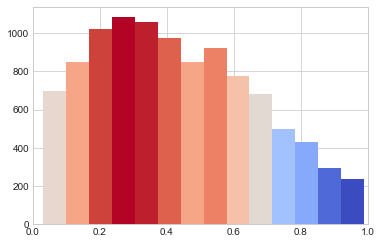

In [20]:
hist(full_history['valence'], [0, 1])
full_history['valence'].describe()

The release date isn't accurate either. For example, all classical music has release dates of 1960 or later, since this is the release of the album itself, not necessarily the conception of the music (which would have placed a lot of this genre in the 17th-20th centuries).

In [21]:
full_history = full_history.drop('release', axis=1)

How much music are we talking about here?

In [53]:
total_hours = full_history['duration'].sum()/(60)
print('Total hours: {:0.3f}'.format(total_hours))

hours_per_day = total_hours/(full_history['timestamp'].max() - full_history['timestamp'].min()).days
print('Hours/day: {:0.1f}'.format(hours_per_day))

avg_song_dur = full_history['duration'].mean()
print('Average songs/day: {:0.0f}'.format(hours_per_day/(avg_song_dur/(60.0))))

print('Total songs listened to: {} (unique songs: {})'.format(len(full_history), len(get_unique())))

Total hours: 667.877
Hours/day: 5.0
Average songs/day: 78
Total songs listened to: 10362 (unique songs: 5390)


In [22]:
full_history.sample(5)

,acousticness,album,artists,danceability,energy,explicit,id,key,mode,name,popularity,speechiness,tempo,time_signature,timestamp,valence,duration,log_loudness
8826,0.78200,17,[15UsOTVnJzReFVN1VCnxy4],0.746,0.251,1,5TXDeTFVRVY7Cvt0Dw4vWW,11,0,Revenge,79,0.2590,140.0,4,2018-04-21 17:15:00-07:00,0.180,2.000450,2.843105
4374,0.01420,Alien Boy EP,[6TLwD7HPWuiOzvXEa3oCNe],0.666,0.774,1,62BKMNUacuQ6X67ID4Qcef,1,1,Welcome To LA,55,0.2470,104.0,4,2018-02-28 11:41:00-08:00,0.437,2.527567,1.904344
5695,0.00329,Wolf,[4V8LLVI7PbaPR0K2TGSxFF],0.368,0.838,1,6rqj2zeKhLy3exkuFi6mSz,8,0,Answer,62,0.0487,72.0,4,2018-02-13 09:42:00-08:00,0.477,3.834450,2.010225
10037,0.37400,The Beautiful Game,"[4AGwPDdh1y8hochNzHy5HC, 5WId4o5jdGVhptNU0uqKxu]",0.443,0.643,0,1kRTlW6idFA2IGhJrMmiyF,2,1,The Beautiful Game,53,0.0386,105.0,4,2017-12-25 13:03:00-08:00,0.451,4.543117,2.017433
1394,0.04350,Mercury,[3QqJ1L8cWsPFZ1YDPpUmvG],0.614,0.802,0,72e9D8QX35Zn2Bp3cnRZfs,0,0,Robots,22,0.1100,128.0,4,2018-04-06 13:41:00-07:00,0.202,4.151917,1.504966


## What kinds of music do I listen to?

What types of genres?

In [23]:
artists_index = pd.Index(artists['id'])

def addTrackGenres(row):
    inner_gs = []
        
    # for each artist in a track
    for track_artist in row['artists']:
                        
        # if the artist exists, get its index
        i = artists_index.get_loc(track_artist)
        if i > -1:
            cell = artists.iloc[i, 2]
            if cell:
                # collect genres from artists that match the current index
                inner_gs.append(cell)
                
    if inner_gs:
        row['genres'] = np.unique(list(itertools.chain(*inner_gs)))
    else:
        row['genres'] = None
        
    return row


In [24]:
full_history = full_history.apply(addTrackGenres, 1)

In [25]:
genres = []
counts = []
freqs =  []
var1 =   []

for i, row in full_history.loc[full_history['genres'].notnull(), ['energy', 'genres']].iterrows():
    
    for genre in row['genres']:
        
        if genre in genres:
            i = genres.index(genre)
            counts[i] += 1
            var1[i] += row['energy']
        else:
            genres.append(genre)
            counts.append(1)
            var1.append(row['energy'])

total = sum(counts)
freqs = np.array(counts) / total
var1 = np.array(var1) / np.array(counts)

collective_genres = pd.DataFrame({'freq': freqs, 'count': counts, 'genre': genres, 'var1': var1})

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


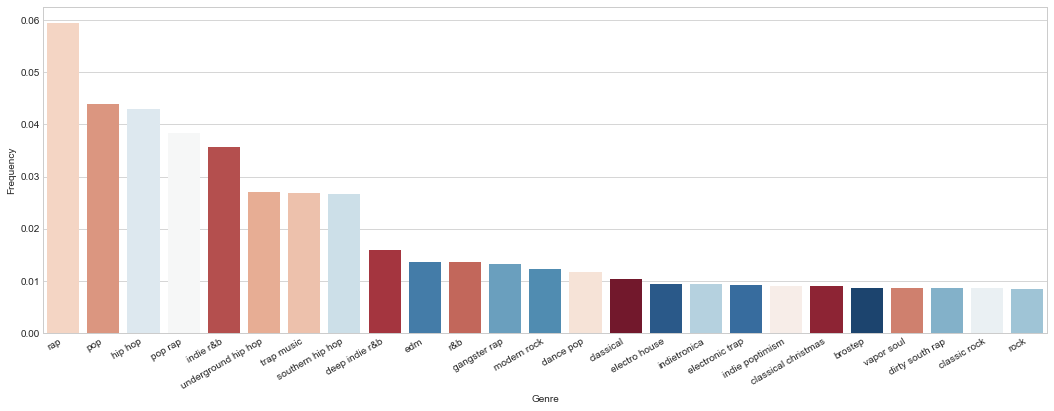

In [26]:
offset = 0
collective_genres = collective_genres.sort_values('freq', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='genre', y='freq', 
                data=collective_genres[offset:offset+25], 
                hue='var1', palette='RdBu', dodge=False)
g.legend_.remove()
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');
plt.xlabel('Genre')
plt.ylabel('Frequency');

What is the overall mood like?

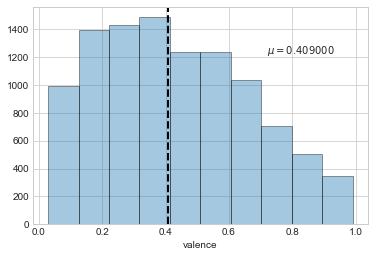

In [27]:
ax = sns.distplot(full_history.valence, bins=10, kde=False, hist_kws={"edgecolor": "k", "linewidth":1})
plt.axvline(full_history.valence.median(), color='k', linestyle='--', linewidth=2);
plt.text(0.8, 0.8, r'$\mu={0:2f}$'.format(full_history.valence.median()), 
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes);

Most listened to artists

In [55]:
collective_artists = [artist for artist in full_history.loc[full_history['artists'].notnull(), 'artists']]
    
collective_artists = np.array(list(itertools.chain(*collective_artists)))
unique_artists, artist_counts = np.unique(collective_artists, return_counts=True)

artist_df = pd.DataFrame({'id': unique_artists, 'count': artist_counts})
artist_df = pd.merge(artist_df, artists, on='id')[['id', 'artist', 'count', 'genres']]

def simplifyGenre(x):
    for genre in collective_genres['genre']:
        if genre in x:
            return genre
        
    return 'other'

artist_df['genres'] = artist_df['genres'].apply(simplifyGenre)

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


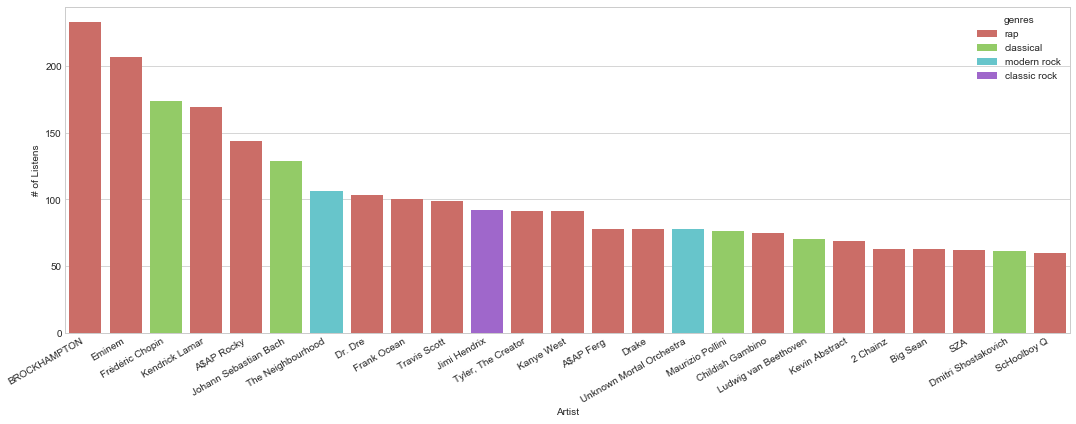

In [56]:
offset = 0
sort_artist_df = artist_df.sort_values('count', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='artist', y='count', data=sort_artist_df[offset:offset+25], hue='genres', dodge=False, palette='hls')
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');
plt.xlabel('Artist');
plt.ylabel('# of Listens');
plt.savefig('topartists.png')

Duration of songs:

The mean song is 3:52 minutes, the median is 3:40 minutes, and 75% of my music is shorter than 4:19 minutes. My five longest songs include two European classical pieces, two Indian classical pieces, and SB-01, an experimental track by Unknown Mortal Orchestra.

In [54]:
print(pd.Series(full_history['duration']).describe())
full_history.sort_values('duration')[['name', 'duration']].tail(5)

count    10362.000000
mean         3.867266
std          1.405493
min          0.566450
25%          3.156017
50%          3.666667
75%          4.321529
max         41.074900
Name: duration, dtype: float64


,name,duration
990,Raag Mishra Shirvranjani Taal Deepchandi,21.820150
3046,"Piano Concerto No. 1 in B-Flat Minor, Op. 23: ...",22.037783
7033,SB-01,22.143333
5655,"Tod und Verklärung Op.24, TrV 158",27.024000
966,"Rag Bhimpalasi: Alap, Jod, Jhala",41.074900


## When do I listen to music?

How have I deviated from the above mentioned 78 songs per day?

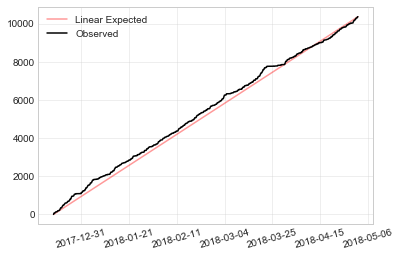

In [77]:
#plt.plot(x=full_history['timestamp'].index, y=full_history['timestamp'].values)
dates = full_history['timestamp'].sort_values().reset_index(drop=True)
plt.xticks(rotation=15)
plt.plot([min(full_history['timestamp']), max(full_history['timestamp'])], 
         [0, max(dates.index)], 
         'r-', alpha=0.4, label='Linear Expected')
plt.plot(dates.values, dates.index, c='k', label='Observed')
plt.legend()
plt.grid(alpha=0.4)

Heatmap

In [29]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

In [30]:
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)

In [31]:
def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [32]:
full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)

In [33]:
def _averageDatetimeFrequency(df, hour_inc):
    hour_bins = np.arange(0, 24+hour_inc, hour_inc)
    hour_labels = np.arange(hour_inc, 24+hour_inc, hour_inc)

    df['time_bin'] = pd.cut(df['hour_decimal'], bins=hour_bins, labels=hour_labels)
    
    history_time_bivar = df.groupby(['weekday', 'time_bin'], axis=0)
    return history_time_bivar.size().unstack().fillna(0)

def plotAverageDatetimeFrequency(data, title='', fs=(12,5), hour_inc=0.5):
    plt.subplots(figsize=fs)
    plt.title('Average Listening Date-time Frequency{}'.format(title))
    g = sns.heatmap(_averageDatetimeFrequency(data, hour_inc), cmap="Blues", robust=True)
    plt.xlabel('Time Bin')
    plt.ylabel('Weekday')
    g.set(yticklabels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']); # use ; to suppress output

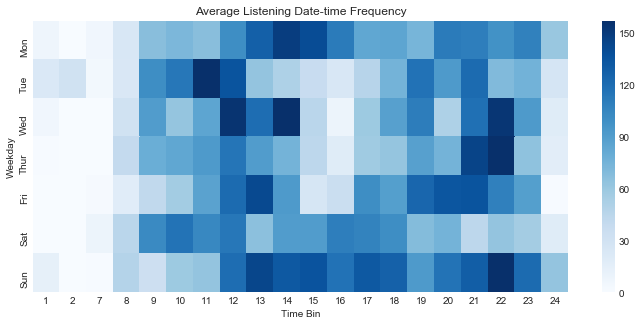

In [45]:
plotAverageDatetimeFrequency(full_history, hour_inc=1)

In [46]:
inc = 1

hour_labels = np.arange(inc, 24+inc, inc)
day_bins = np.arange(0,7)

genres_matrix = []

w = []
for day in day_bins:
    d = []
    for hour in hour_labels:
        genres = full_history.loc[(full_history['weekday'] == day) & (full_history['time_bin'] == hour), 'genres']
        
        if list(genres):
            unique_genres, genres_counts = np.unique(list(itertools.chain(*genres.dropna())), return_counts=True)
            i, = np.where(genres_counts==genres_counts.max())
            i = i[0]
            d.append(str(unique_genres[i]))
        else:
            d.append('none')
    w.append(d)
    
d = pd.DataFrame(w)

In [47]:
u = np.unique(d)
u = dict(zip(u, range(len(u))))
d = d.replace(u)

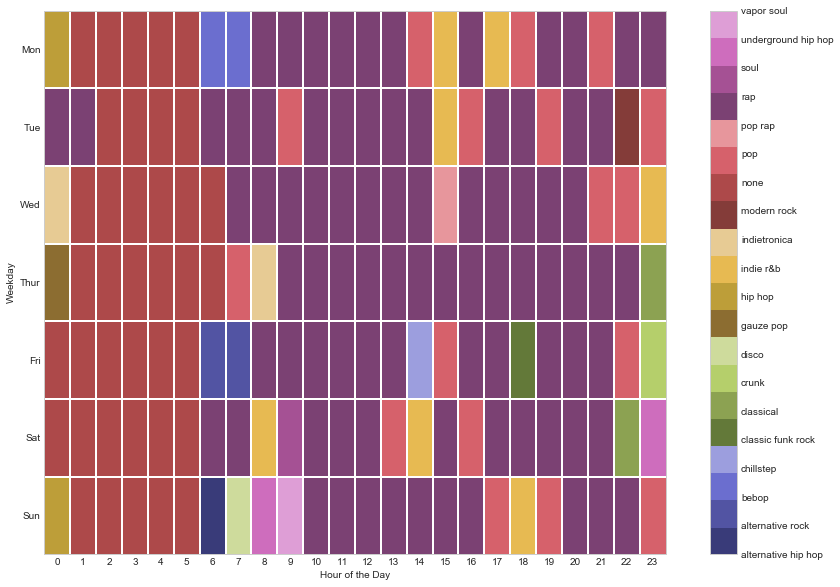

In [48]:
fig, ax = plt.subplots(figsize=(16,10))
im = plt.imshow(d, cmap='tab20b', aspect=3)

cb = fig.colorbar(im)
cb.set_ticks(list(u.values()))
cb.set_ticklabels(list(u.keys()))  # put text labels on them

# Major ticks
ax.set_xticks(np.arange(0, 24, 1));
ax.set_yticks(np.arange(0, 7, 1));

# Minor ticks
ax.set_xticks(np.arange(-.5, 23, 1), minor=True);
ax.set_yticks(np.arange(-.5, 6, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', b=False)

ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

plt.xlabel('Hour of the Day')
plt.ylabel('Weekday');

Morning vs Afternoon vs Evening

In [ ]:
full_history

When I listen to music, how much do I listen to? We create the idea of a listening cluster, which is simply a period of time in which I listened to consecutive music. In one cluster, I might listen to just a single song, or 20 songs back-to-back, or a few hours of music on end.

We examine this by creating clusters which depend the time between one song and the next being less than the duration of latter song plus five minutes. This five minute gap allows little breaks to be had, but still include continue the chain of songs.

It turns out that I usually listen to music in bouts of about 7 to 48 minutes. The most I've listened to in one cluster is 405 minutes, or 6 hours and 45 minutes.

In [34]:
times = full_history[['timestamp', 'duration']]
times['timestamp'] = pd.DatetimeIndex(times['timestamp']).view('int64') // pd.Timedelta(1, unit='s')
times = times.sort_values('timestamp')

latter = np.array(times.iloc[1:, 0])
former = np.array(times.iloc[:-1, 0])
raw_deltas = latter - former

deltas = times[1:].drop('timestamp', axis=1)
deltas.loc[:, 'duration'] *= 60
deltas.loc[:, 'delta'] = np.array(raw_deltas)

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    1006.000000
mean       35.974451
std        45.828728
min         0.000000
25%         7.396100
50%        20.506325
75%        47.617837
max       404.734067
dtype: float64

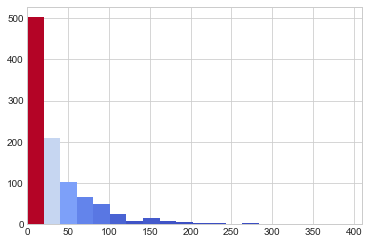

In [35]:
clusters = []
current_cluster = 0

MAXIMUM_GAP = 300

for i, row in deltas.iterrows():
    if row['duration'] + MAXIMUM_GAP > row['delta']:
        current_cluster += row['duration']
    else:
        clusters.append(current_cluster)
        current_cluster = 0

clusters.append(current_cluster)
clusters = pd.Series(clusters) / 60
hist(clusters, [0, 410], 20)
clusters.describe()

## What music do I *actually* like?

With thousands of songs in my music listening history, it should be obvious that I don't *love* all of them. If we wish to describe the songs I like, the dataset must be labeled with whether I like a particular song. In other words, we extract implicit feedback to classify songs as "Like" or "Dislike." Implicit feedback is easier to collect because it does not require individually labeling each sample. Here, we define this feedback as listening frequency. It is assumed that songs that are enjoyed are listened to more often than songs that are not enjoyed.

There are two flavors of frequency feedback: absolute and relative. Absolute frequency feedback (AFF) is the listening frequency within the know period of recording. Relative frequency feedback (RFF) is the listening frequency between the first and last listening event. AFF accounts for long-term listening habits. RFF accounts for songs that were enjoyed during one period in time (and may still be enjoyed).

In [ ]:
day_range = (full_history['timestamp'].max() - full_history['timestamp'].min()).days

In [ ]:
unique_counts = []

last = full_history['timestamp'].max()

for i, row_outer in full_history.iterrows():
    matches = full_history.loc[full_history['id'] == row_outer['id'], 'timestamp']
    
    n = len(matches)
        
    ts = np.array(matches.sort_values())
    spread = int((ts.max() - ts.min()) / 8.64e13)
    spread = 1 if spread == 0 else spread
    
    rff = 1
    med = 0
    if n > 1:
        deltas = (ts[1:] - ts[:-1]) / 8.64e13
        med = int(np.median(deltas))
        rff = n / spread
    
    distance = last - matches.max()

    unique_counts.append([row_outer['id'], row_outer['name'], n, n / day_range, rff, distance.total_seconds()])
    

In [ ]:
unique = pd.DataFrame(unique_counts, columns=['id', 'name', 'n', 'aff', 'rff', 'distance']).drop_duplicates('id')

In [ ]:
unique['distance_hat'] = round(unique['distance'] / (60 * 60 * 24 * 2))
unique.describe()

In [ ]:
for col in ['aff', 'rff', 'distance_hat']:
    mi = unique[col].min()
    ma = unique[col].max()
    above_zero = -1 if mi > 0 else 1
    unique[col] = (unique[col] + above_zero*mi) / ma
    

In [ ]:
unique.describe()

In [ ]:
clst = cluster.KMeans(2, init='random', n_init=10)

a = unique[0:1000].copy()
#a['rff'] = a['rff'].apply(lambda x: np.log(x+1))

labels = pd.DataFrame({'Y': clst.fit_predict(a[['aff', 'rff', 'distance_hat']])})
a = pd.concat([a, labels], axis=1)
a[a['Y'] == 1]

In [ ]:
unique_all = get_unique().merge(unique_counts, on='id')

In [ ]:
unique_labeled[unique_labeled['like'] == 1]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

## Do I prefer to discover new music or stick with known songs?

Do I have any go-to songs? artists? A go-to song is a song...

Do I have any hidden favorite songs? artists?

How much of my collection is from artists from my list of top artists?

The top 1% of artists ($n=26$) make up 25.9% of songs in my history, the top 5% of artists ($n=181$) make up 51.1% of songs, the top 10% of artists ($n=362$) make up 64.9% of songs, and the top 25% of artists ($n=906$) make up 81.4% of songs.

In [78]:
makeup = []

for portion in [0.01, 0.05, 0.1, 0.25]:
    
    top_portion = round(len(sort_artist_df) * portion)
    top_portion = sort_artist_df.iloc[:top_portion, 0]
    
    total_songs_in_portion = 0
    for i, row in full_history.iterrows():
        # for each track, look through the artists
        for artist in row['artists']:
            # if at least one artist on the song is in the top portion, count it and skip the rest
            if artist in list(top_portion):
                total_songs_in_portion += 1
                break
            
    makeup.append([len(top_portion), total_songs_in_portion / len(full_history)])
    
makeup = np.array(makeup)

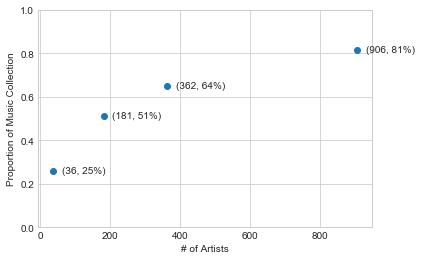

In [79]:
plt.scatter(x=makeup[:, 0], y=makeup[:, 1])

for elm in makeup:
    plt.annotate('({}, {}%)'.format(int(elm[0]), int(elm[1]*100)), (elm[0], elm[1]), (elm[0]+25, elm[1]-0.01))

plt.xlabel('# of Artists')
plt.ylabel('Proportion of Music Collection')
plt.ylim([0,1]);

55.3% of artists I've listened to,  only once!

In [85]:
len(sort_artist_df[sort_artist_df['count'] == 1])/len(sort_artist_df)

0.5532560706401766

# Is my music collection mainstream?

Compared to what most people are listening to, am I any different? (I'd like to think so, but we'll see)

In [36]:
mainstream = pd.read_json('data/mainstream_music.json')

In [ ]:
mainstream['tempo'] = mainstream['tempo'].apply(round)
mainstream['tempo'] = mainstream['tempo'].apply(lambda x: x if x < 168 else x/2)

count    10362.000000
mean       111.641671
std         25.434972
min         32.000000
25%         90.000000
50%        110.000000
75%        132.000000
max        167.000000
Name: tempo, dtype: float64

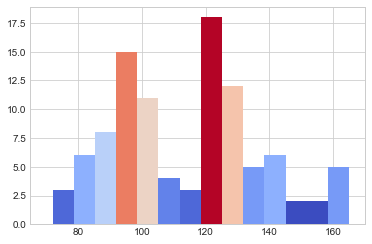

In [41]:
hist(mainstream['tempo'], [65,170])
full_history['tempo'].describe()

In [42]:
mainstream['duration'] = mainstream['duration_ms'] / 1000 / 60
mainstream = mainstream.drop('duration_ms', axis=1)

count    100.000000
mean       3.656737
std        0.704452
min        2.402483
25%        3.239679
50%        3.487367
75%        3.873775
max        7.476217
Name: duration, dtype: float64


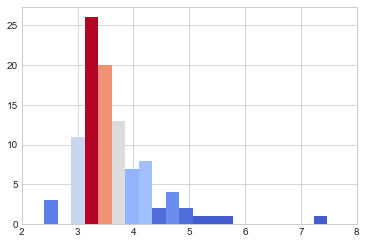

In [43]:
hist(mainstream['duration'], [2,8], 21)
print(mainstream['duration'].describe())

In [44]:
mainstream = mainstream.drop('liveness', axis=1)